# Part 1: Dataset Simulation

In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from google import genai
import json
import os
from dotenv import load_dotenv
import re

In [2]:
# CONFIGURATION
load_dotenv()
API_KEY = os.getenv("API_KEY")
client = genai.Client(api_key=API_KEY)

In [ ]:

# DEFINE THE GENAI FUNCTION for TEXT GENERATION
def generate_customer_feedback(persona, sentiment, model="gemini-2.0-flash", num_sentences=200):
    """
    Sends a prompt to Gemini to generate realistic text and returns a list of strings.
    This function is defensive: it will try multiple parsing strategies and always
    return a list of length `num_sentences` (padding/repeating if necessary).
    """
    prompt = f"""
    You are simulating a customer database for a bank.
    Generate exactly {num_sentences} unique, realistic customer feedback sentences (10-20 words each).

    Customer Profile: {persona}
    Sentiment:{sentiment}

    - If 'Young Adult': Mention apps, crypto, student loans, splitting bills, fast cash. Use casual language.
    - If 'Professional': Mention interest rates, mortgages, wire transfers, business accounts. Use formal language.
    - If 'Retiree': Mention branches, pensions, passwords, phone support, safety. Use polite but confused language.

    - If Sentiment is 'Positive': Praise speed, features, or service.
    - If Sentiment is 'Negative': Complain about fees, crashes, delays, or rejections.

    Output format: A raw JSON list of strings. Example: ["text1", "text2"]
    Do not add Markdown formatting or extra text.
    """

    try:
        response = client.models.generate_content(
            model=model,
            contents=[prompt]
        )

        # Try multiple ways to get text from the response object
        raw_text = None
        if hasattr(response, 'text') and isinstance(response.text, str):
            raw_text = response.text
        else:
            # Fallback to stringifying the response
            raw_text = str(response)

        if raw_text is None:
            raise ValueError("No text found in model response")

        # Remove common code block markers
        cleaned = raw_text.strip().replace("```json", "").replace("```", "")

        # Search for the first JSON array in the response (robust against extra text)
        # Use non-greedy match so we don't accidentally capture across multiple arrays
        match = re.search(r"\[.*?\]", cleaned, re.S)
        json_text = match.group(0) if match else cleaned

        parsed = json.loads(json_text)

        # Normalize to list of non-empty strings
        if isinstance(parsed, list):
            texts = [str(x).strip() for x in parsed if isinstance(x, str) and str(x).strip()]
        else:
            # If model returned a dict or other structure, try to find strings inside
            texts = []
            def _extract_strings(obj):
                if isinstance(obj, str):
                    return [obj]
                if isinstance(obj, dict):
                    out = []
                    for v in obj.values():
                        out.extend(_extract_strings(v))
                    return out
                if isinstance(obj, list):
                    out = []
                    for v in obj:
                        out.extend(_extract_strings(v))
                    return out
                return []
            texts = [s.strip() for s in _extract_strings(parsed) if s and s.strip()]

        # If we still have nothing, raise to hit the exception handler below
        if not texts:
            raise ValueError("Parsed response contained no usable strings")

        # Ensure exactly num_sentences are returned: if fewer, repeat/shuffle to pad
        if len(texts) < num_sentences:
            # If there are some unique texts, repeat them to reach requested count
            orig = texts.copy()
            i = 0
            while len(texts) < num_sentences and orig:
                texts.append(orig[i % len(orig)])
                i += 1
        elif len(texts) > num_sentences:
            texts = texts[:num_sentences]

        return texts

    except Exception as e:
        print(f" Error fetching/parsing from Gemini: {e}")
        # Return a deterministic fallback list of the requested length
        return ["Error generating text." for _ in range(num_sentences)]


data_cache = {
        "young_adult": {"positive": [], "negative": []},
        "professional": {"positive": [], "negative": []},
        "retiree": {"positive": [], "negative": []}
    }

# --- Young Adult ---
ya_positive = generate_customer_feedback("Young Adult", "Positive")
ya_negative = generate_customer_feedback("Young Adult", "Negative")

# --- Professional ---
pro_positive = generate_customer_feedback("Professional", "Positive")
pro_negative = generate_customer_feedback("Professional", "Negative")

# --- Retiree ---
ret_positive = generate_customer_feedback("Retiree", "Positive")
ret_negative = generate_customer_feedback("Retiree", "Negative")

In [ ]:
def get_feedback_text(persona, is_default):
    """
    Selects a random feedback string based on Persona and Default Status.
    """
    # 1. Determine Base Sentiment
    # Default = 1 means they are high risk/struggling -> likely Negative feedback
    # Default = 0 means they are repaying -> likely Positive feedback
    use_negative_sentiment = (is_default == 1)

    # 2. Add "Noise"
    if random.random() < 0.10:
        use_negative_sentiment = not use_negative_sentiment

    selected_list = []
    
    # 3. Select the appropriate list based on Persona and Sentiment
    if persona == "young_adult":
        selected_list = ya_negative if use_negative_sentiment else ya_positive
    elif persona == "professional":
        selected_list = pro_negative if use_negative_sentiment else pro_positive
    elif persona == "retiree":
        selected_list = ret_negative if use_negative_sentiment else ret_positive

    # 4. Return a random sentence from selected list
    if not selected_list:
        return "Service was okay."      
    return random.choice(selected_list)

In [ ]:
# SIMULATE DATASET 
fake = Faker()
Faker.seed(42)

def generate_data(num_records=1000):
    data = []

    for _ in range(num_records):
        # --- Demographics ---
        profile = fake.profile()
        customer_id = f"CUST-{fake.unique.random_int(min=100000, max=999999)}"
        gender = profile['sex']
        age = random.randint(18, 80)


        # Simulate 3 types customer persona: Young Adult, Professional, Retiree
        if age < 25:
            persona = "young_adult"
            job = np.random.choice(["Student", "Intern", "Part-time Server", "Barista", "None"])
            income = np.random.normal(15000, 5000)
            spend_score = np.random.normal(70, 10) # High spend relative to income

        elif 25 <= age < 60:
            persona = "professional"
            job = profile['job']
            income = np.random.normal(85000, 25000)
            spend_score = np.random.normal(50, 15)

        else:
            persona = "retiree"
            job = "retired"
            income = np.random.normal(45000, 10000)
            spend_score = np.random.normal(30, 10) # Low spend


        # --- Transactional Numerics ---
        #  Credit score
        if persona == "professional":
            credit_score = int(np.random.normal(720, 50))
        elif persona == "young_adult":
            credit_score = int(np.random.normal(600, 80))
        else:
            credit_score = int(np.random.normal(680, 60))
        
        credit_score = max(300, min(850, credit_score)) #real world limits (300-850)

        # Account balance
        if persona == "young_adult":
            savings_rate = np.random.normal(0.05, 0.02)
            accumulation_factor = random.uniform(0.1, 1.0)

        elif persona == "professional":
            savings_rate = np.random.normal(0.20, 0.05)
            accumulation_factor = random.uniform(1.0, 3.0)

        else: # Retiree
            savings_rate = np.random.normal(0.08, 0.04)
            accumulation_factor = random.uniform(2.0, 5.0)

        savings_rate = max(0.01, min(0.50, savings_rate))
        account_balance = (income * savings_rate) * accumulation_factor * random.uniform(0.1, 1.5)
        
        # Loan Request Details
        max_possible_loan = income * 0.6
        loan_amount = round(random.uniform(2000, max_possible_loan), 2)
        loan_term = random.choice([12, 24, 36, 60])

        risk_probability = 0.1 # Base 10% risk
        
        # Rule 1: Low Credit Score increases risk significantly
        if credit_score < 580: risk_probability += 0.40
        elif credit_score < 650: risk_probability += 0.20
        
        # Rule 2: High Loan-to-Income ratio increases risk
        dti_ratio = loan_amount / income
        if dti_ratio > 0.4: risk_probability += 0.25
        
        # Rule 3: Additional risk for Young Adults
        if persona == "young_adult": risk_probability += 0.05

        # Cap probability at 0.95 
        risk_probability = min(0.95, risk_probability)

        is_default = 1 if random.random() < risk_probability else 0


        # --- 4. Feedback Text Column ---
        feedback_text = get_feedback_text(persona, is_default)
        
        record = {
            "Customer_ID": customer_id,
            "Age": age,
            "Gender": gender,
            "Persona": persona,
            "Job": job,
            "Annual_Income": round(income, 2),
            "Credit_Score": credit_score,
            "Account_Balance": round(account_balance, 2),
            "Spending_Score": round(spend_score, 2),
            "Loan_Amount": loan_amount,
            "Loan_Term_Months": loan_term,
            "Loan_Default": is_default, #
            "Customer_Feedback": feedback_text
        }
        data.append(record)

    return pd.DataFrame(data)

# Generate and View
df_customers = generate_data(1000)
print(df_customers.head())

In [ ]:
# Save to CSV
df_customers.to_csv('financial_data_simulated.csv', index=False)
print(f"Dataset saved to 'financial_data_simulated.csv'")

# Part 2: Feature Engineering and Data Cleaning (refined)

In [3]:
# Run this cell to use the CSV if you prefer not to regenerate the dataset in Part 1
if os.path.exists('financial_data_simulated.csv'):
    try:
        df_customers = pd.read_csv('financial_data_simulated.csv')
        print('Loaded financial_data_simulated.csv with shape', df_customers.shape)
    except Exception as e:
        print('Could not load CSV, using in-memory df_customers if present:', e)

# -----------------------------
# Configuration
# -----------------------------
# Small lexicons for quick polarity heuristics
POS_WORDS = {"good", "great", "fast", "love", "excellent", "happy", "satisfied", "helpful", "smooth", "easy", "secure", "reliable", "thank", "appreciate", "convenient", "peace"}
NEG_WORDS = {"bad", "complain", "poor", "angry", "fraud", "delay", "crash", "issue", "problem", "expensive", "fee", "fees", "late", "refuse", "rejected", "unacceptable", "exorbitant"}

EPS = 1e-9
TOP_JOB_K = 7  # how many top jobs to create one-hot for

# LLM sentiment extraction
LLM_BATCH_SIZE = 100
LLM_MODEL = 'gemini-2.0-flash'

# Simple mapping of job keywords to coarse job categories (reduces cardinality)
JOB_KEYWORDS = {
    'health': ['nurse', 'physic', 'clinic', 'health', 'doctor', 'therapist', 'pharm', 'care', 'hospital'],
    'research': ['research', 'analyst', 'scientist', 'academic', 'lecturer'],
    'education': ['teacher', 'professor', 'educat', 'tutor', 'school'],
    'finance': ['bank', 'finance', 'account', 'auditor', 'financial', 'investment', 'insur'],
    'it': ['developer', 'engineer', 'software', 'program', 'it ', 'data ', 'analytics', 'tech', 'system'],
    'service': ['server', 'barista', 'waiter', 'retail', 'customer service', 'service'],
    'gov': ['government', 'public', 'civil'],
}

# -----------------------------
# Helper functions
# -----------------------------

def normalize_job(job_str):
    if not isinstance(job_str, str) or job_str.strip().lower() in {'none', 'missing'}:
        return 'missing'
    js = job_str.strip().lower()
    # remove punctuation and common separators
    js = js.replace('/', ' ').replace(',', ' ').replace('-', ' ')
    # map to keyword categories
    for cat, keywords in JOB_KEYWORDS.items():
        for kw in keywords:
            if kw in js:
                return cat
    # fallback: collapse repetitive whitespace
    return 'other_' + '_'.join(js.split()[:3])  # keep up to first 3 tokens to reduce cardinality


def safe_to_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

# Lightweight LLM sentiment helper
def llm_feedback_sentiment(texts):
    """
    Return list of (label, score) for each input text.
    - label: 'positive'|'neutral'|'negative'
    - score: float between -1.0 and 1.0
    Uses the GenAI client in batches. LLM is always called for every batch; lexical fallback is only used for individual LLM failures within a batch.
    """
    out = []
    # lexical fallback local helper (only for individual LLM failures)
    def _lexical(t):
        t_l = (t or "").lower()
        pos_cnt = sum(1 for w in t_l.split() if any(p == w or w.startswith(p) for p in POS_WORDS))
        neg_cnt = sum(1 for w in t_l.split() if any(n == w or w.startswith(n) for n in NEG_WORDS))
        polarity = pos_cnt - neg_cnt
        if polarity > 0:
            label = 'positive'; score = min(1.0, polarity / 5.0)
        elif polarity < 0:
            label = 'negative'; score = max(-1.0, polarity / 5.0)
        else:
            label = 'neutral'; score = 0.0
        return (label, float(score))

    # Batch request to the LLM
    for i in range(0, len(texts), LLM_BATCH_SIZE):
        batch = texts[i:i+LLM_BATCH_SIZE]
        print(f"Running LLM sentiment for records {i+1} to {i+len(batch)}...")
        prompt = (
            "You are a sentiment annotator. For each input sentence return a JSON array of objects with fields "
            '"label" and "score". Label MUST be one of: positive, neutral, negative. '
            'Score MUST be a float between -1.0 and 1.0 (negative -> positive sentiment). '
            'Return ONLY a single JSON array (no extra text).\n\n'
            "Inputs:\n"
        )
        for t in batch:
            prompt += f"- {t}\n"
        try:
            resp = client.models.generate_content(model=LLM_MODEL, contents=[prompt])
            raw = resp.text if hasattr(resp, 'text') else str(resp)
            m = re.search(r"\[.*?\]", raw, re.S)
            payload = m.group(0) if m else raw
            parsed = json.loads(payload)
            # ensure parsed is a list of dict-like objects
            for obj in parsed:
                if not isinstance(obj, dict):
                    out.append(_lexical(""))
                    continue
                lab = obj.get('label', 'neutral')
                sc = obj.get('score', 0.0)
                # Normalize label and score
                lab = str(lab).lower()
                if lab not in {'positive', 'neutral', 'negative'}:
                    lab = 'neutral'
                try:
                    scf = float(sc)
                except Exception:
                    scf = 0.0
                scf = max(-1.0, min(1.0, scf))
                out.append((lab, scf))
        except Exception as e:
            print(f"LLM batch failed for records {i+1} to {i+len(batch)}: {e}")
            # On any LLM error, fallback to lexical for this batch
            for t in batch:
                out.append(_lexical(t))

    # ensure length matches input
    if len(out) < len(texts):
        out.extend([('neutral', 0.0)] * (len(texts) - len(out)))
    return out


Loaded financial_data_simulated.csv with shape (1000, 13)


In [4]:

# -----------------------------
# Feature engineering function
# -----------------------------

def feature_enginner(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    # Standardize a few columns
    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].astype(str).str.upper().map({'M':'M','F':'F','': 'U'}).fillna('U')
    if 'Persona' in df.columns:
        df['Persona'] = df['Persona'].astype(str).fillna('missing')

    # Numeric coercion
    for c in ['Age','Annual_Income','Credit_Score','Account_Balance','Spending_Score','Loan_Amount','Loan_Term_Months','Loan_Default']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Missing indicators + simple imputations
    for c in ['Age','Annual_Income','Credit_Score','Account_Balance','Spending_Score','Loan_Amount','Loan_Term_Months']:
        if c in df.columns:
            df[f'{c}_missing'] = df[c].isna().astype(int)
            med = df[c].median()
            df[c] = df[c].fillna(med)

    for c in ['Gender','Persona','Job','Customer_Feedback']:
        if c in df.columns:
            df[f'{c}_missing'] = df[c].isna().astype(int)
            df[c] = df[c].fillna('Missing').astype(str)

    # Normalize Job into coarse categories to reduce cardinality
    if 'Job' in df.columns:
        df['Job_norm'] = df['Job'].apply(normalize_job)

    # Clip extreme outliers by percentile and keep raw copies
    clip_cols = ['Annual_Income','Account_Balance','Loan_Amount','Spending_Score','Credit_Score','Age']
    for c in clip_cols:
        if c in df.columns:
            low = df[c].quantile(0.01)
            high = df[c].quantile(0.99)
            df[f'{c}_raw'] = df[c]
            df[c] = df[c].clip(lower=low, upper=high)

    # Log transforms for skewed monetary features
    for c in ['Annual_Income','Account_Balance','Loan_Amount']:
        if c in df.columns:
            df[f'{c}_log1p'] = np.log1p(df[c].clip(lower=0))

    # Derived features (ratios and interactions)
    if {'Loan_Amount','Annual_Income'}.issubset(df.columns):
        df['loan_to_income'] = df['Loan_Amount'] / (df['Annual_Income'] + EPS)
    if {'Loan_Amount','Account_Balance'}.issubset(df.columns):
        df['loan_to_balance'] = df['Loan_Amount'] / (df['Account_Balance'] + EPS)
    if {'Account_Balance','Annual_Income'}.issubset(df.columns):
        df['balance_to_income'] = df['Account_Balance'] / (df['Annual_Income'] + EPS)
    if {'Loan_Amount','Loan_Term_Months'}.issubset(df.columns):
        df['monthly_loan_payment_est'] = df['Loan_Amount'] / (df['Loan_Term_Months'] + EPS)
    if 'Age' in df.columns and 'Annual_Income' in df.columns:
        df['income_per_age'] = df['Annual_Income'] / (df['Age'] + EPS)

    # Credit score buckets
    if 'Credit_Score' in df.columns:
        def credit_bucket(score):
            try:
                s = float(score)
            except Exception:
                return 'unknown'
            if s < 580: return 'low'
            if s < 670: return 'medium'
            if s < 740: return 'good'
            return 'excellent'
        df['credit_bucket'] = df['Credit_Score'].apply(credit_bucket)

    # Age groups
    if 'Age' in df.columns:
        def age_group(a):
            if a < 25: return 'young'
            if a < 45: return 'adult'
            if a < 65: return 'mid'
            return 'senior'
        df['age_group'] = df['Age'].apply(age_group)

    # Text / NLP features from Customer_Feedback (lexical)
    def feedback_lexical_features(text: str):
        if not isinstance(text, str):
            text = ''
        text_l = text.lower()
        chars = len(text)
        words = text_l.split()
        wc = len(words)
        avg_wlen = float(np.mean([len(w) for w in words])) if words else 0.0
        pos_cnt = sum(1 for w in words if any(p == w or w.startswith(p) for p in POS_WORDS))
        neg_cnt = sum(1 for w in words if any(n == w or w.startswith(n) for n in NEG_WORDS))
        polarity = pos_cnt - neg_cnt
        qmark = int('?' in text)
        exclaim = int('!' in text)
        capital_words = sum(1 for w in text.split() if w.isupper() and len(w) > 1)
        has_url = int('http' in text.lower())
        return {
            'feedback_char_count': chars,
            'feedback_word_count': wc,
            'feedback_avg_word_len': avg_wlen,
            'feedback_pos_count': pos_cnt,
            'feedback_neg_count': neg_cnt,
            'feedback_polarity': polarity,
            'feedback_has_question': qmark,
            'feedback_has_exclaim': exclaim,
            'feedback_capital_words': capital_words,
            'feedback_has_url': has_url,
        }

    if 'Customer_Feedback' in df.columns:
        lex = df['Customer_Feedback'].apply(feedback_lexical_features).apply(pd.Series)
        df = pd.concat([df, lex], axis=1)

        # LLM-driven sentiment
        try:
            texts = df['Customer_Feedback'].fillna('').astype(str).tolist()
            llm_out = llm_feedback_sentiment(texts)
            df['feedback_llm_label'] = [lab for lab, sc in llm_out]
            df['feedback_llm_score'] = [sc for lab, sc in llm_out]
        except Exception as e:
            # worst-case fallback: neutral for all
            df['feedback_llm_label'] = ['neutral'] * len(df)
            df['feedback_llm_score'] = [0.0] * len(df)
            print('LLM sentiment failed, used neutral fallback:', e)

    # Encode small categoricals (one-hot) and Job_norm via frequency/top-K
    for c in ['Gender','Persona','credit_bucket','age_group']:
        if c in df.columns:
            dummies = pd.get_dummies(df[c], prefix=c)
            df = pd.concat([df, dummies], axis=1)

    if 'Job_norm' in df.columns:
        counts = df['Job_norm'].value_counts()
        topk = counts.head(TOP_JOB_K).index.tolist()
        df['job_norm_freq'] = df['Job_norm'].map(counts).fillna(0)
        for i, j in enumerate(topk, start=1):
            df[f'job_norm_top_{i}'] = np.where(df['Job_norm'] == j, 1, 0)
        df['job_norm_top_other'] = np.where(~df['Job_norm'].isin(topk), 1, 0)

    # Final numeric coercions
    final_numeric = ['Age','Annual_Income','Credit_Score','Account_Balance','Spending_Score','Loan_Amount','Loan_Term_Months','Loan_Default',
                     'loan_to_income','loan_to_balance','balance_to_income','monthly_loan_payment_est','income_per_age']
    for c in final_numeric:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

    # Keep a short list of columns recommended for modeling
    recommended_features = [c for c in df.columns if any(x in c for x in ['loan_to_','credit_','age_','feedback_','job_','Annual_Income','Account_Balance','Loan_Amount','Credit_Score'])]
    df.attrs['recommended_features_sample'] = recommended_features[:60]

    return df


# -----------------------------
# Run refined engineering and quick validations
# -----------------------------
print('Raw dataset shape:', df_customers.shape)
df_clean = feature_enginner(df_customers)
print('Cleaned dataset shape:', df_clean.shape)

# Basic validations
print('\nCustomer_ID unique:', df_clean['Customer_ID'].nunique() == df_clean.shape[0])
print('Credit bucket counts:\n', df_clean['credit_bucket'].value_counts(dropna=False))
print('\nSample feedback features (first 5 rows):')
print(df_clean[['Customer_ID','Customer_Feedback','feedback_word_count','feedback_polarity','feedback_has_question','feedback_has_exclaim']].head())

# Save cleaned dataset for reproducibility
try:
    df_clean.to_csv('financial_data_cleaned.csv', index=False)
    print('\nSaved cleaned dataset to financial_data_cleaned.csv')
except Exception as e:
    print('Could not save cleaned CSV:', e)


Raw dataset shape: (1000, 13)
Running LLM sentiment for records 1 to 100...
LLM batch failed for records 1 to 100: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.0-flash\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.0-flash\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 0, model: gemini-2.0-flash\nPlease retry in 19.491568146s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn 

In [ ]:
df_clean

# Part 3: Exploratory Data Analysis (EDA)

In [15]:
# For further step purposes, load df_clean instead of running all of the above parts again
if os.path.exists('financial_data_cleaned.csv'):
    df_clean = pd.read_csv('financial_data_cleaned.csv')
    print('Loaded financial_data_cleaned.csv with shape', df_clean.shape)
else:
    print('financial_data_cleaned.csv not found, using in-memory df_clean if present.')

Loaded financial_data_cleaned.csv with shape (1000, 75)


df_clean shape: (1000, 75)
Columns: ['Customer_ID', 'Age', 'Gender', 'Persona', 'Job', 'Annual_Income', 'Credit_Score', 'Account_Balance', 'Spending_Score', 'Loan_Amount', 'Loan_Term_Months', 'Loan_Default', 'Customer_Feedback', 'Age_missing', 'Annual_Income_missing', 'Credit_Score_missing', 'Account_Balance_missing', 'Spending_Score_missing', 'Loan_Amount_missing', 'Loan_Term_Months_missing', 'Gender_missing', 'Persona_missing', 'Job_missing', 'Customer_Feedback_missing', 'Job_norm', 'Annual_Income_raw', 'Account_Balance_raw', 'Loan_Amount_raw', 'Spending_Score_raw', 'Credit_Score_raw', 'Age_raw', 'Annual_Income_log1p', 'Account_Balance_log1p', 'Loan_Amount_log1p', 'loan_to_income', 'loan_to_balance', 'balance_to_income', 'monthly_loan_payment_est', 'income_per_age', 'credit_bucket', 'age_group', 'feedback_char_count', 'feedback_word_count', 'feedback_avg_word_len', 'feedback_pos_count', 'feedback_neg_count', 'feedback_polarity', 'feedback_has_question', 'feedback_has_exclaim', 'feedb

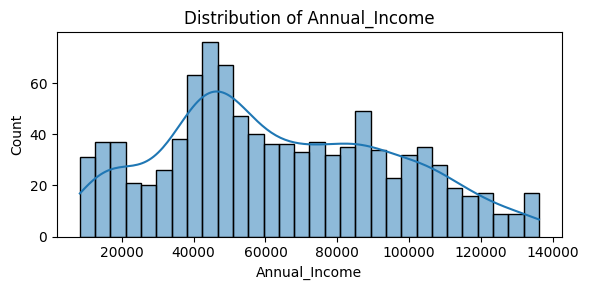

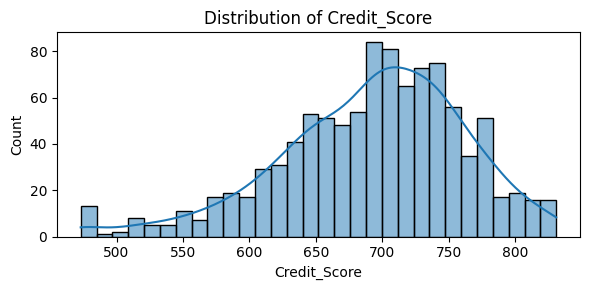

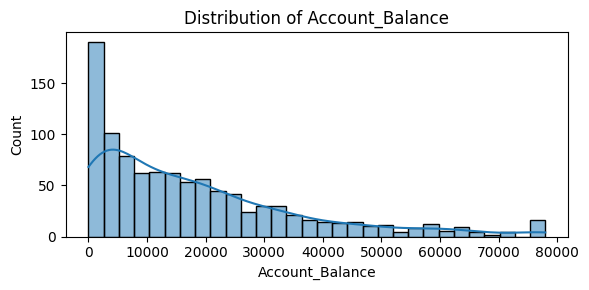

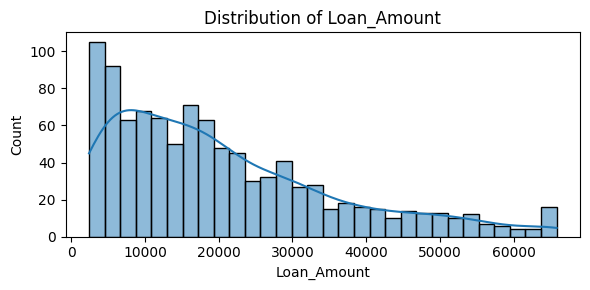

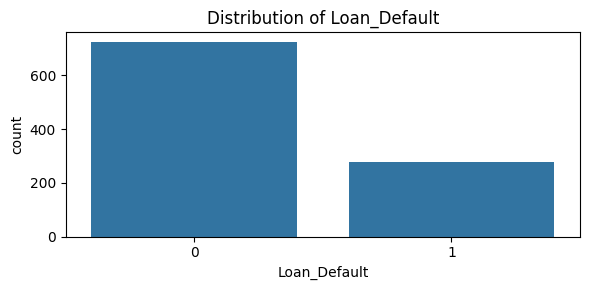

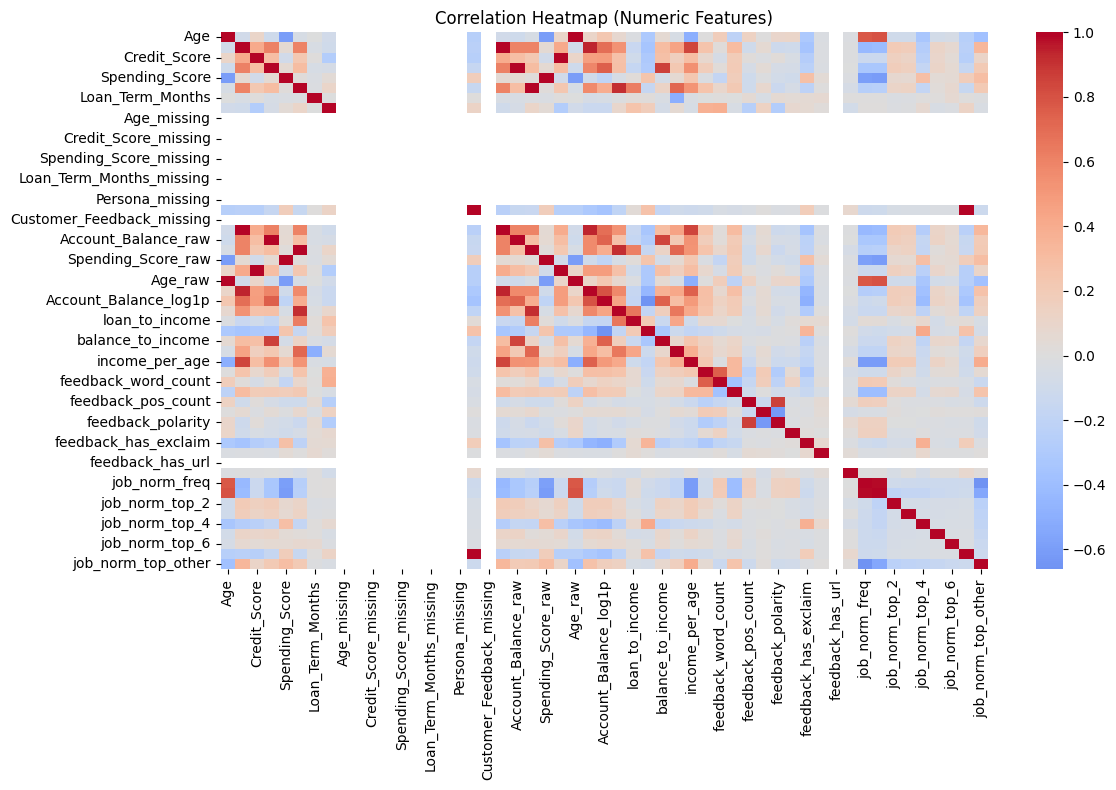

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Shape and columns
print('df_clean shape:', df_clean.shape)
print('Columns:', df_clean.columns.tolist())

# 2. Summary statistics for numeric columns
print('\nSummary statistics:')
print(df_clean.describe().T)

# 3. Value counts for key categoricals
categorical_cols = ['Gender', 'Persona', 'credit_bucket', 'age_group']
for col in categorical_cols:
    if col in df_clean.columns:
        print(f'\nValue counts for {col}:')
        print(df_clean[col].value_counts(dropna=False))

# 4. Missing values
print('\nMissing values per column:')
print(df_clean.isnull().sum())

# 5. Sample rows
print('\nSample rows:')
print(df_clean.head())

# 6. Plot distributions for key features
features_to_plot = ['Annual_Income', 'Credit_Score', 'Account_Balance', 'Loan_Amount', 'Loan_Default']
for feat in features_to_plot:
    if feat in df_clean.columns:
        plt.figure(figsize=(6, 3))
        if df_clean[feat].nunique() < 20:
            sns.countplot(x=feat, data=df_clean)
        else:
            sns.histplot(df_clean[feat], kde=True, bins=30)
        plt.title(f'Distribution of {feat}')
        plt.tight_layout()
        plt.show()

# 7. Correlation heatmap (numeric features)
numeric_cols = df_clean.select_dtypes(include=[float, int]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean[numeric_cols].corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()



## Predictive Model Development

# Part 4: Model Building

## 4.1 ML Model utility methods for all models

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    mean_squared_error,
    f1_score,
    recall_score,
    precision_score
)
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
# LOAD & PREPARE DATA
df = pd.read_csv('financial_data_cleaned.csv')

# Define Target Variable
target = 'Loan_Default'

# Define Features (X) by dropping non-predictive or raw text columns
# Drop original categorical columns if they have already been One-Hot Encoded
cols_to_drop = [
    'Loan_Default',      # The target itself
    'Customer_ID',       # Unique ID, no predictive value
    'Customer_Feedback', # Raw text (we use 'feedback_llm_score' instead)
    'Job', 'Job_norm',   # High cardinality categorical text
    'Gender', 'Persona', # Categorical (we use the encoded 'Gender_F', 'Persona_young_adult' etc.)
    'credit_bucket', 'age_group', 'feedback_llm_label'
]

X = df.drop(columns=cols_to_drop, errors='ignore')
y = df[target]

# Ensure all boolean (True/False) columns are converted to 0/1 for the model
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

In [8]:
# SPLIT DATA (Train/Test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training on {X_train.shape[0]} rows, Testing on {X_test.shape[0]} rows.")

Training on 800 rows, Testing on 200 rows.


### Model 1 - Random Forest Classifier

In [9]:
# BUILD & TRAIN MODEL

# Initialize Random Forest with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

print("\nTraining Random Forest Model...")
rf_model.fit(X_train, y_train)
print("----Training Complete.----")


Training Random Forest Model...
----Training Complete.----



Model Accuracy: 81.00%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       147
           1       0.70      0.49      0.58        53

    accuracy                           0.81       200
   macro avg       0.77      0.71      0.73       200
weighted avg       0.80      0.81      0.80       200

ROC AUC: 0.8344243357720448


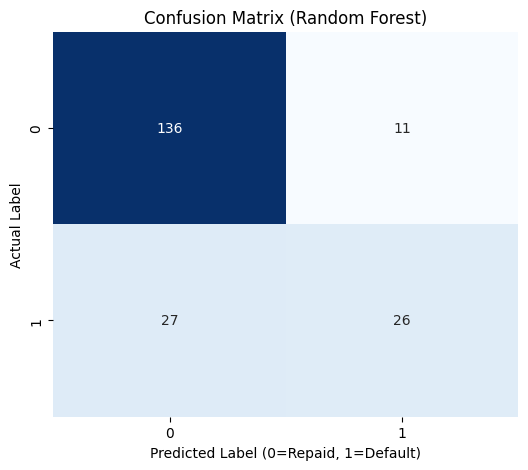

In [10]:
# EVALUATION & METRICS

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# A. Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")

# B. Detailed Classification Report (Precision, Recall, F1)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# C. ROC and AUC Score
if hasattr(rf_model, 'predict_proba'):
    try:
        print('ROC AUC:', roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))
    except Exception:
        pass
    
# D. Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted Label (0=Repaid, 1=Default)')
plt.ylabel('Actual Label')
plt.show()


/tmp/ipykernel_15010/2584960669.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')


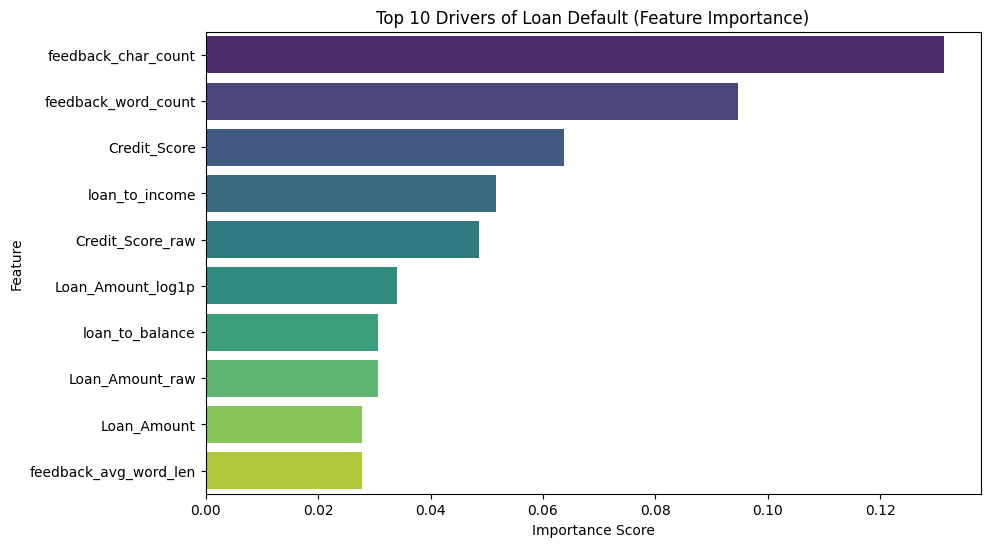

In [11]:
# FEATURE IMPORTANCE

# Extracts the top 10 features that influenced the model the most
importances = rf_model.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title('Top 10 Drivers of Loan Default (Feature Importance)')
plt.xlabel('Importance Score')
plt.show()

In [12]:
# HYPERPARAMETER TUNING

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [2, 4, 6],
    'class_weight': [None, 'balanced']
}

# Stratified K-Fold Cross-Validation -> Splits data into 5 chunks, preserving the ratio of Defaulters in each chunk
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1)

print("Starting Hyperparameter Tuning ...")

rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print('\nBest RF params:', rf_grid.best_params_)
print(f"\nBest ROC-AUC Score (CV): {rf_grid.best_score_:.4f}")

Starting Hyperparameter Tuning ...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best RF params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Best ROC-AUC Score (CV): 0.8860


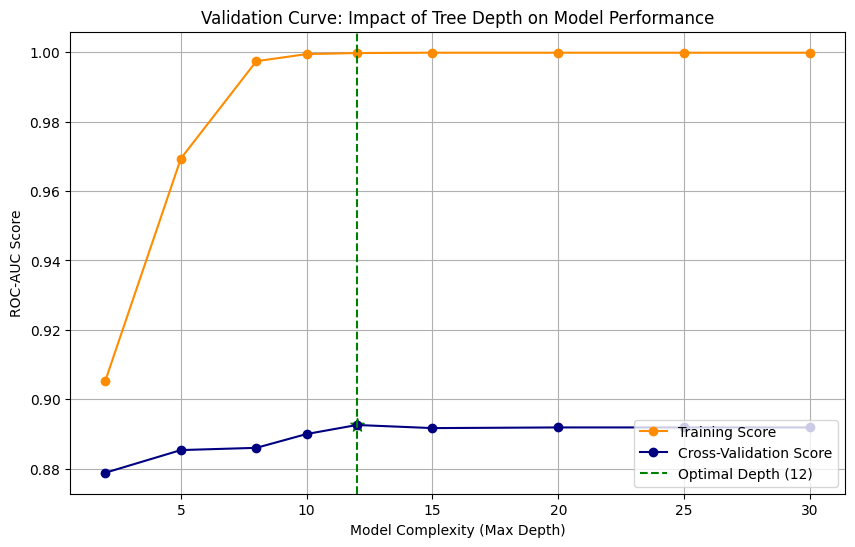

Interpretation:
The validation curve confirms that a Max Depth of 12 provides the best balance (ROC-AUC: 0.893).


In [13]:
from sklearn.model_selection import validation_curve

# Analysis Model Complexity (Validation Curve)

param_range = [2, 5, 8, 10, 12, 15, 20, 25, 30]

train_scores, test_scores = validation_curve(
    best_rf,
    X_train, y_train,
    param_name="max_depth",
    param_range=param_range,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Score", color="darkorange", marker='o')
plt.plot(param_range, test_mean, label="Cross-Validation Score", color="navy", marker='o')

# Mark the Optimal Point
best_depth_idx = np.argmax(test_mean)
best_depth = param_range[best_depth_idx]
best_score = test_mean[best_depth_idx]

plt.axvline(x=best_depth, color='green', linestyle='--', label=f'Optimal Depth ({best_depth})')
plt.scatter(best_depth, best_score, s=100, c='green', marker='*') # Add a star!

plt.title("Validation Curve: Impact of Tree Depth on Model Performance")
plt.xlabel("Model Complexity (Max Depth)")
plt.ylabel("ROC-AUC Score")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Interpretation:\nThe validation curve confirms that a Max Depth of {best_depth} provides the best balance (ROC-AUC: {best_score:.3f}).")


Model Accuracy: 79.50%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       147
           1       0.62      0.60      0.61        53

    accuracy                           0.80       200
   macro avg       0.74      0.73      0.74       200
weighted avg       0.79      0.80      0.79       200


ROC AUC: 0.8340392760877935


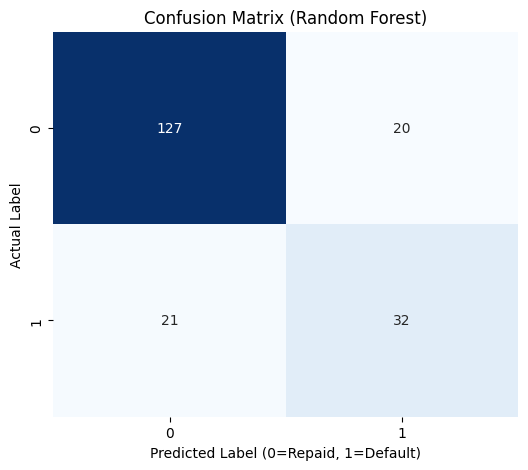

In [14]:
# EVALUATION ON TEST SET WITH BEST MODEL
y_pred = best_rf.predict(X_test)

# A. Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")

# B. Detailed Classification Report
print('\n--- Classification Report ---')
print(classification_report(y_test, y_pred))

# C. ROC and AUC Score
if hasattr(best_rf, 'predict_proba'):
    try:
        print('\nROC AUC:', roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))
    except Exception:
        pass

# D. Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted Label (0=Repaid, 1=Default)')
plt.ylabel('Actual Label')
plt.show()

### Model 2 - XGBoost

In [15]:
# Initialize XGBoost classifier with sensible defaults
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

print('\nTraining XGBoost Model...')
# Fit on the training set
xgb_model.fit(X_train, y_train)
print('----Training Complete.----')


Training XGBoost Model...


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [06:48:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


----Training Complete.----



Model Accuracy: 79.00%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       147
           1       0.61      0.58      0.60        53

    accuracy                           0.79       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.79      0.79      0.79       200

ROC AUC: 0.8277


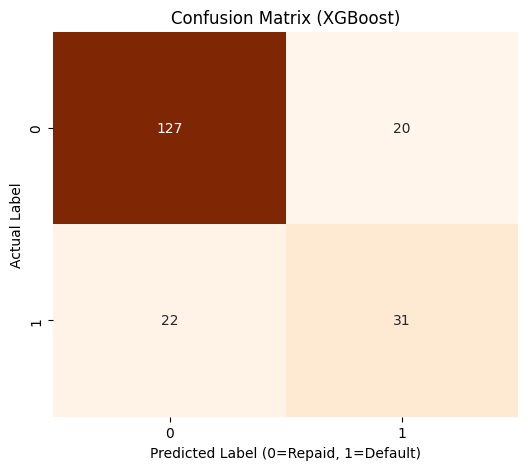

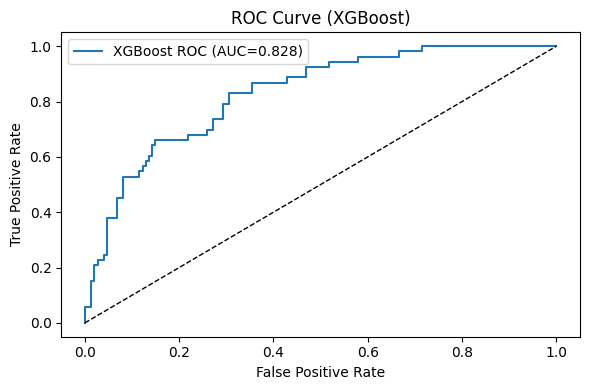

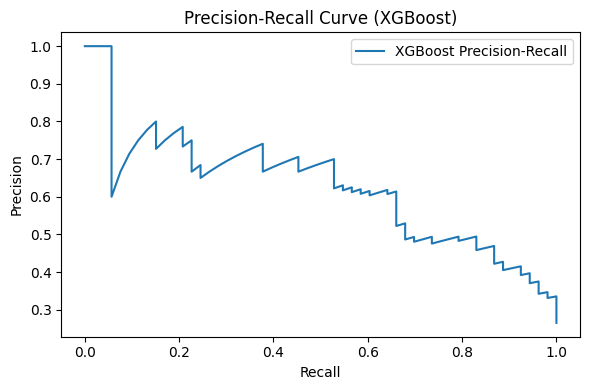

/tmp/ipykernel_15010/640091492.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df_xgb, palette='magma')


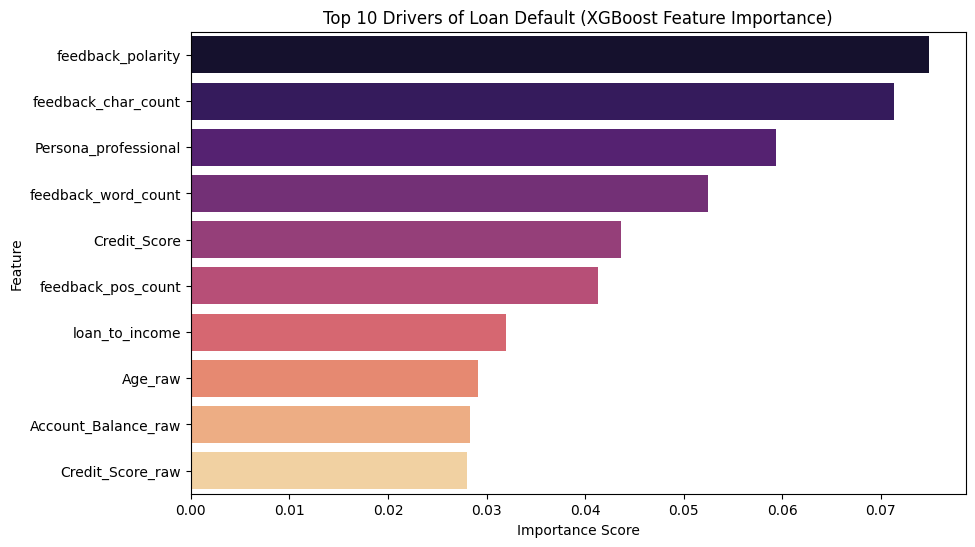

In [16]:
# Evaluation (keeps the existing evaluation code intact)
try:
    y_pred_xgb = xgb_model.predict(X_test)
    y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
except Exception:
    y_pred_xgb = xgb_model.predict(X_test)
    y_proba_xgb = y_pred_xgb.astype(float)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
try:
    roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
except Exception:
    roc_auc_xgb = None

print(f"\nModel Accuracy: {accuracy_xgb:.2%}")
print('\n--- Classification Report ---')
print(classification_report(y_test, y_pred_xgb))
if roc_auc_xgb is not None:
    print(f'ROC AUC: {roc_auc_xgb:.4f}')

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted Label (0=Repaid, 1=Default)')
plt.ylabel('Actual Label')
plt.show()

# ROC curve
if roc_auc_xgb is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC={roc_auc_xgb:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (XGBoost)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Precision-Recall
try:
    prec, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, prec, label='XGBoost Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (XGBoost)')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    pass

# Feature importance (top 10)
try:
    importances_xgb = xgb_model.feature_importances_
    feature_names = X.columns
    feat_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_xgb})
    feat_df_xgb = feat_df_xgb.sort_values(by='Importance', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_df_xgb, palette='magma')
    plt.title('Top 10 Drivers of Loan Default (XGBoost Feature Importance)')
    plt.xlabel('Importance Score')
    plt.show()
except Exception:
    print('Could not extract XGBoost feature importances.')


### Model 3 - KNN

In [17]:
# Check for Underfit/Overfit using different K values
k_values = range(1, 31)  # test K from 1 to 30
train_scores = []
test_scores = []

for k in k_values:
    knn_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])

    knn_pipeline.fit(X_train, y_train)

    train_acc = knn_pipeline.score(X_train, y_train)
    test_acc  = knn_pipeline.score(X_test, y_test)

    train_scores.append(train_acc)
    test_scores.append(test_acc)

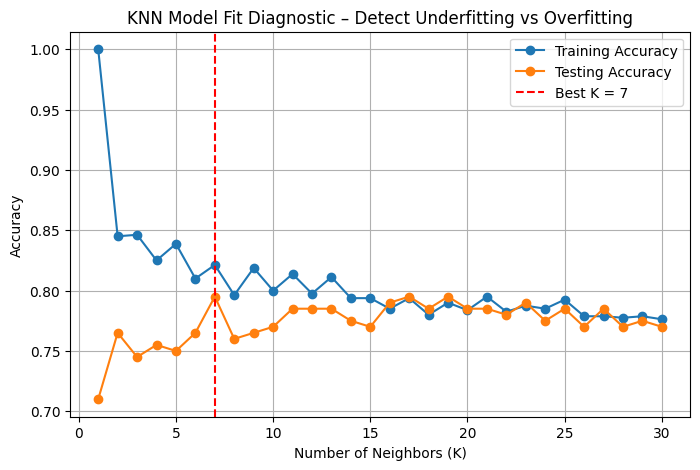


Best K = 7 (Highest Test Accuracy 79.50%)


In [18]:
# Plot Training vs Testing Accuracy
plt.figure(figsize=(8,5))
plt.plot(k_values, train_scores, label="Training Accuracy", marker='o')
plt.plot(k_values, test_scores, label="Testing Accuracy", marker='o')
plt.axvline(x=np.argmax(test_scores)+1, color='red', linestyle='--',
            label=f"Best K = {np.argmax(test_scores)+1}")


plt.title("KNN Model Fit Diagnostic – Detect Underfitting vs Overfitting")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nBest K = {np.argmax(test_scores)+1} (Highest Test Accuracy {max(test_scores):.2%})")


KNN model complexity is changed by adjusting the number of neighbors (K=1 to K=30).
The experiment successfully demonstrates three classical learning behaviours:

- Overfitting was observed at low K (e.g., K=1–3), where training accuracy approached 100% while testing accuracy was significantly lower.

- Optimal fitting occurred around K=7, where the model achieved the highest testing accuracy with a minimal train-test gap, indicating good generalization.

- Underfitting appeared at high K values (e.g., K>20), where both training and testing accuracy decreased, implying overly smooth decision boundaries.

These findings validate the robustness of the modelling pipeline, as the model reacts to complexity changes in a theoretically consistent manner.

In [19]:
# Train Final Model using Best K
best_k = np.argmax(test_scores)+1
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

print("\nTraining Final KNN Model...")
knn_pipeline.fit(X_train, y_train)
print("Training Complete.")


Training Final KNN Model...
Training Complete.



Final Model Accuracy: 79.50%
ROC AUC: 0.7786
RMSE: 0.3980

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       147
           1       0.68      0.43      0.53        53

    accuracy                           0.80       200
   macro avg       0.75      0.68      0.70       200
weighted avg       0.78      0.80      0.78       200



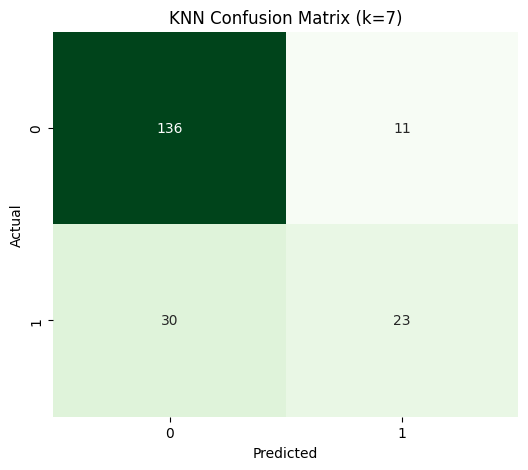

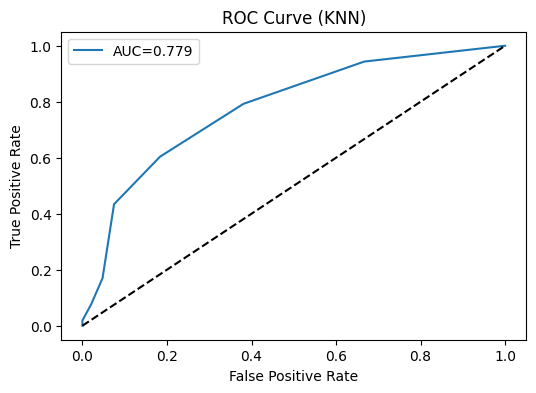

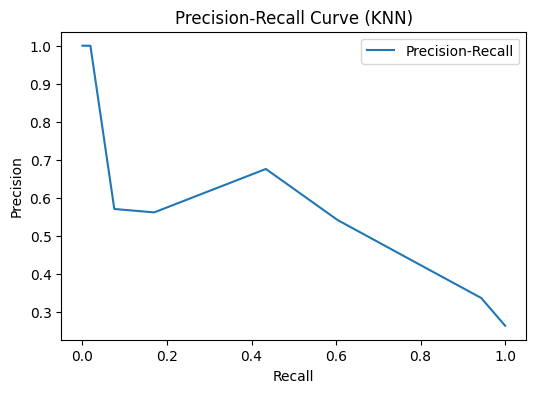

/tmp/ipykernel_15010/395707178.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_df, palette="coolwarm")


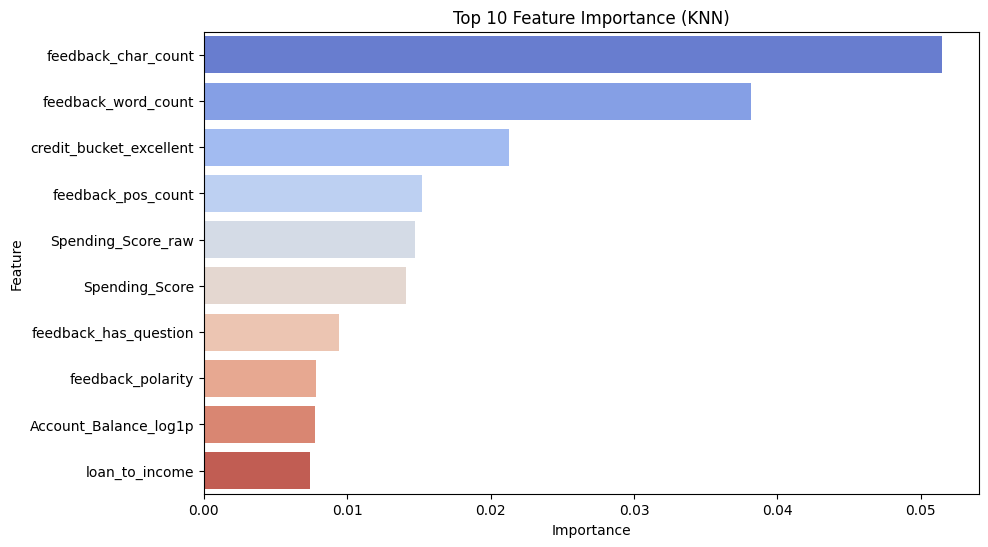

In [20]:
# Model Evaluation
y_pred = knn_pipeline.predict(X_test)
y_proba = knn_pipeline.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
rmse = np.sqrt(mean_squared_error(y_test, y_proba))

print(f"\nFinal Model Accuracy: {accuracy:.2%}")
print(f"ROC AUC: {auc:.4f}")
print(f"RMSE: {rmse:.4f}\n")
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cmap='Greens', cbar=False)
plt.title(f"KNN Confusion Matrix (k={best_k})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (KNN)")
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label="Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (KNN)")
plt.legend()
plt.show()

# Permutation Feature Importance
from sklearn.inspection import permutation_importance

perm = permutation_importance(knn_pipeline, X_test, y_test,
                              n_repeats=10, scoring='roc_auc', random_state=42)

feat_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": perm.importances_mean,
    "Std": perm.importances_std
}).sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_df, palette="coolwarm")
plt.title("Top 10 Feature Importance (KNN)")
plt.show()


### Model 4 - Base decision tree

In [21]:
# Train Baseline Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:, 1] if hasattr(dt, "predict_proba") else None

print("Baseline Decision Tree")
print("Accuracy:", f"{accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))
if y_proba is not None:
    try:
        print("ROC AUC:", f"{roc_auc_score(y_test, y_proba):.4f}")
    except Exception:
        pass

Baseline Decision Tree
Accuracy: 73.00%
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       147
           1       0.49      0.62      0.55        53

    accuracy                           0.73       200
   macro avg       0.67      0.70      0.68       200
weighted avg       0.75      0.73      0.74       200

ROC AUC: 0.6957


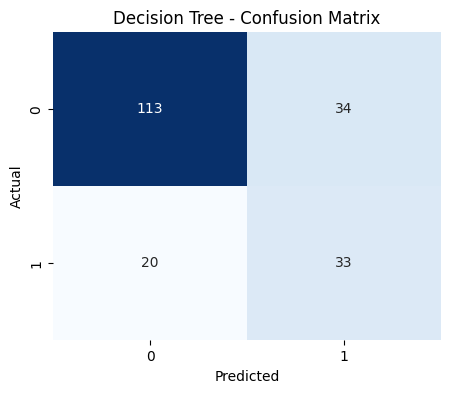

/tmp/ipykernel_15010/363706188.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette="viridis")


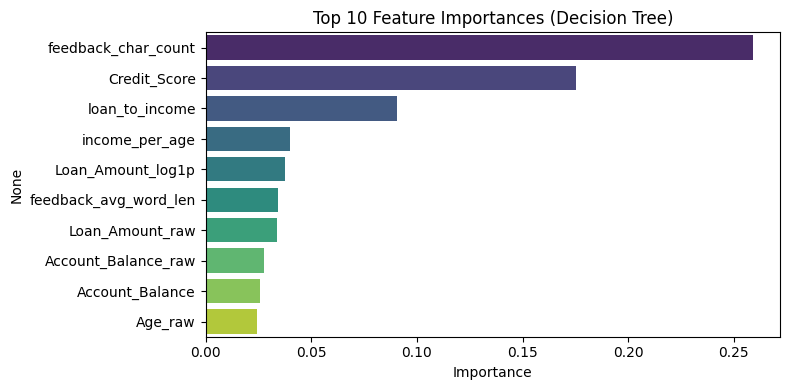

Fitting 5 folds for each of 90 candidates, totalling 450 fits

GridSearch Best Params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Decision Tree
Accuracy: 0.7900
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       147
           1       0.60      0.60      0.60        53

    accuracy                           0.79       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.79      0.79      0.79       200

ROC AUC: 0.7891


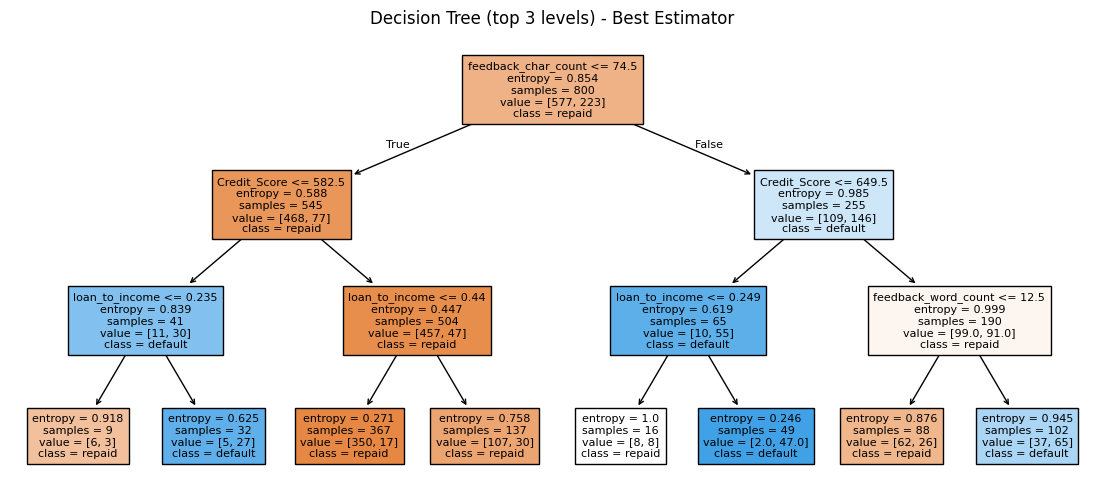

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importances (top 10)
fi = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=fi.values, y=fi.index, palette="viridis")
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Small Grid Search for hyperparameters (fast)
param_grid = {
    "max_depth": [3, 5, 8, 12, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

best_dt = gs.best_estimator_
print("\nGridSearch Best Params:", gs.best_params_)
y_pred_best = best_dt.predict(X_test)
y_proba_best = best_dt.predict_proba(X_test)[:, 1] if hasattr(best_dt, "predict_proba") else None

print("Best Decision Tree")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_best):.4f}")
print(classification_report(y_test, y_pred_best))
if y_proba_best is not None:
    try:
        print("ROC AUC:", f"{roc_auc_score(y_test, y_proba_best):.4f}")
    except Exception:
        pass

# Plot a shallow visualization of the best tree for interpretability
plt.figure(figsize=(14,6))
plot_tree(best_dt, feature_names=X_train.columns, class_names=["repaid","default"], filled=True, max_depth=3, fontsize=8)
plt.title("Decision Tree (top 3 levels) - Best Estimator")
plt.show()

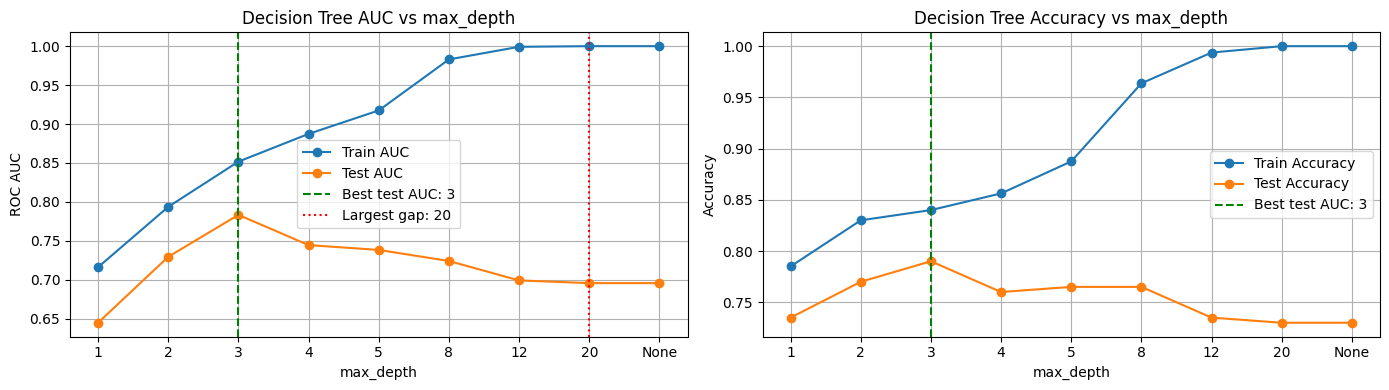

 Current GridSearch best_dt.max_depth = 3 (type: int)
 test AUC at best_dt.max_depth: 0.7833


In [23]:
# Decision Tree complexity sweep (max_depth) to demonstrate underfit/best/overfit behaviour
depths = [1, 2, 3, 4, 5, 8, 12, 20, None]
train_auc = []
test_auc = []
train_acc = []
test_acc = []
labels = [str(d) for d in depths]
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    # probabilities fallback to predictions if not available
    try:
        y_tr_proba = clf.predict_proba(X_train)[:, 1]
        y_te_proba = clf.predict_proba(X_test)[:, 1]
    except Exception:
        y_tr_proba = clf.predict(X_train).astype(float)
        y_te_proba = clf.predict(X_test).astype(float)
    train_auc.append(roc_auc_score(y_train, y_tr_proba))
    test_auc.append(roc_auc_score(y_test, y_te_proba))
    train_acc.append(accuracy_score(y_train, clf.predict(X_train)))
    test_acc.append(accuracy_score(y_test, clf.predict(X_test)))

# Convert to arrays for easy computation
import numpy as _np
train_auc = _np.array(train_auc)
test_auc = _np.array(test_auc)
train_acc = _np.array(train_acc)
test_acc = _np.array(test_acc)

# Locate best (highest test AUC), most-overfitting (largest train-test AUC gap), and most-underfitting (lowest test AUC)
best_idx = int(_np.nanargmax(test_auc))
gap = train_auc - test_auc
overfit_idx = int(_np.nanargmax(gap))
underfit_idx = int(_np.nanargmin(test_auc))

# Plot AUC and Accuracy vs max_depth
x = range(len(depths))
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
# AUC
axes[0].plot(x, train_auc, label='Train AUC', marker='o')
axes[0].plot(x, test_auc, label='Test AUC', marker='o')
axes[0].axvline(best_idx, color='green', linestyle='--', label=f'Best test AUC: {labels[best_idx]}')
axes[0].axvline(overfit_idx, color='red', linestyle=':', label=f'Largest gap: {labels[overfit_idx]}')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('ROC AUC')
axes[0].set_title('Decision Tree AUC vs max_depth')
axes[0].legend()
axes[0].grid(True)
# Accuracy
axes[1].plot(x, train_acc, label='Train Accuracy', marker='o')
axes[1].plot(x, test_acc, label='Test Accuracy', marker='o')
axes[1].axvline(best_idx, color='green', linestyle='--', label=f'Best test AUC: {labels[best_idx]}')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Decision Tree Accuracy vs max_depth')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

# If the current best_dt has a different max_depth, show comparison
if 'best_dt' in globals():
    bd = getattr(best_dt, 'max_depth', None)
    print(f' Current GridSearch best_dt.max_depth = {bd} (type: {type(bd).__name__})')
    # Compare test AUC
    try:
        if bd in depths:
            idx = labels.index(str(bd))
            print(f' test AUC at best_dt.max_depth: {test_auc[idx]:.4f}')
        else:
            print(' best_dt.max_depth not in sweep depths; consider enlarging sweep to include None or larger depths')
    except Exception:
        pass

**Decision Tree complexity sweep summary:** <br>
Best test AUC at max_depth=3 -> Test AUC=0.7833, Train AUC=0.8517  <br>

Decision model complexity is changed by adjusting the depth (K=1 to K=20 and K=None).
The experiment successfully demonstrates three classical learning behaviours: <br>

- Underfitting occurs from K=1 to K=2 as both the train and test accuracy decreases.<br>
- Overfitting occurs from K=4 to K=20 as the train accuracy gets to 100% but the test accuracy decreases over the depth. <br>
- The optimum depth for the decision tree model is K=3.

/tmp/ipykernel_15010/1315304159.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = np.trapz(prec, rec)  # approximate area under PR curve


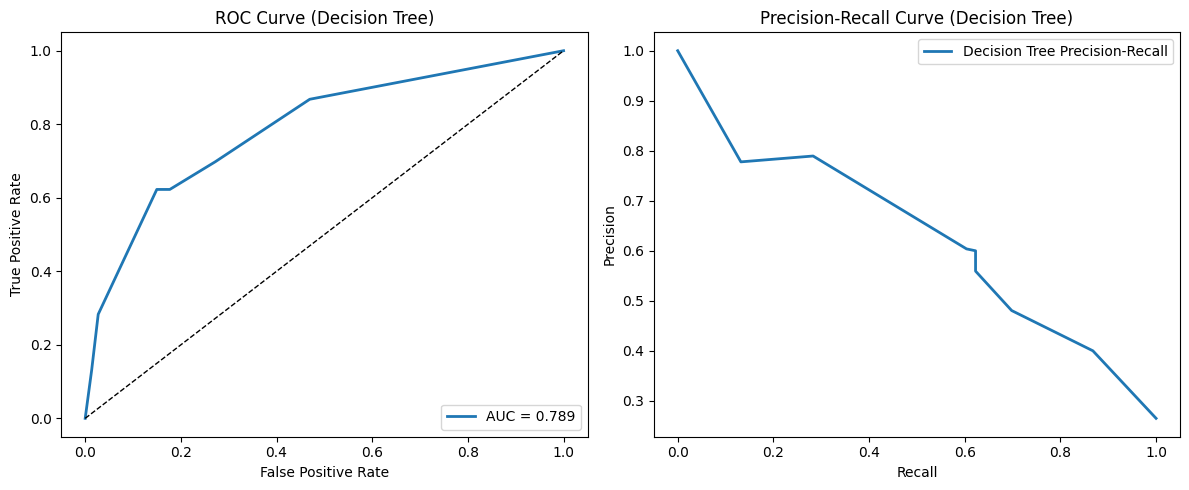

In [24]:
# Assumes: best_dt, X_test, y_test (and optionally y_proba_best) are in the notebook namespace
# Obtain predicted probabilities (fallback to model if y_proba_best not present)
try:
    y_proba_dt = y_proba_best
except NameError:
    if hasattr(best_dt, "predict_proba"):
        y_proba_dt = best_dt.predict_proba(X_test)[:, 1]
    else:
        y_proba_dt = best_dt.predict(X_test).astype(float)

# Compute ROC and PR metrics
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
roc_auc = roc_auc_score(y_test, y_proba_dt)

prec, rec, _ = precision_recall_curve(y_test, y_proba_dt)
ap = np.trapz(prec, rec)  # approximate area under PR curve

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC
axes[0].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
axes[0].plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (Decision Tree)')
axes[0].legend(loc='lower right')

# Precision-Recall
axes[1].plot(rec, prec, lw=2, label="Decision Tree Precision-Recall")
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve (Decision Tree)')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

### Model 5 - Logistic Regression

In [25]:
# Check for Underfit/Overfit using different C values (regularization strength)
# C is the inverse of regularization: smaller C = stronger regularization (simpler model)
# Logarithmic scale from 0.001 to 100
c_values = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100]
train_scores = []
test_scores = []

for c in c_values:
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(C=c, max_iter=1000, random_state=42, solver='lbfgs'))
    ])

    lr_pipeline.fit(X_train, y_train)

    train_acc = lr_pipeline.score(X_train, y_train)
    test_acc  = lr_pipeline.score(X_test, y_test)

    train_scores.append(train_acc)
    test_scores.append(test_acc)

print("C values tested:", c_values)
print("Training scores:", [f"{s:.4f}" for s in train_scores])
print("Testing scores:", [f"{s:.4f}" for s in test_scores])

C values tested: [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100]
Training scores: ['0.7412', '0.8187', '0.8438', '0.8488', '0.8475', '0.8475', '0.8475', '0.8462', '0.8462', '0.8450', '0.8462']
Testing scores: ['0.7500', '0.8350', '0.8100', '0.8250', '0.8200', '0.8150', '0.8150', '0.8150', '0.8150', '0.8150', '0.8150']


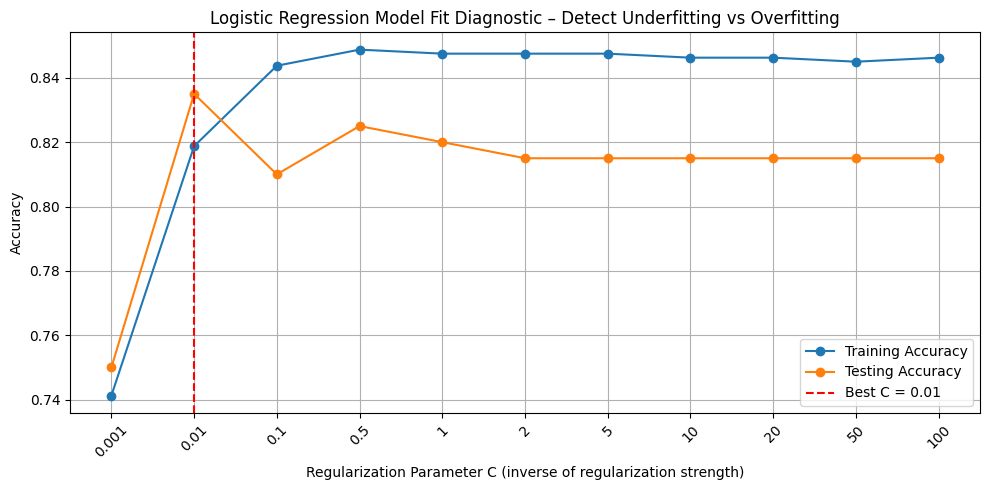

Best C = 0.01 (Highest Test Accuracy 83.50%)


In [26]:
# Plot Training vs Testing Accuracy
plt.figure(figsize=(10,5))
plt.plot(range(len(c_values)), train_scores, label="Training Accuracy", marker='o')
plt.plot(range(len(c_values)), test_scores, label="Testing Accuracy", marker='o')

best_idx = np.argmax(test_scores)
plt.axvline(x=best_idx, color='red', linestyle='--',
            label=f"Best C = {c_values[best_idx]}")

plt.xticks(range(len(c_values)), [f"{c}" for c in c_values], rotation=45)
plt.title("Logistic Regression Model Fit Diagnostic – Detect Underfitting vs Overfitting")
plt.xlabel("Regularization Parameter C (inverse of regularization strength)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best C = {c_values[best_idx]} (Highest Test Accuracy {max(test_scores):.2%})")

In [27]:
# Train Final Model using Best C
best_c = c_values[best_idx]
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=best_c, max_iter=1000, random_state=42, solver='lbfgs'))
])

print("\nTraining Final Logistic Regression Model...")
lr_pipeline.fit(X_train, y_train)
print("Training Complete.")


Training Final Logistic Regression Model...
Training Complete.



Final Model Accuracy: 83.50%
ROC AUC: 0.8392
RMSE: 0.3666

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       147
           1       0.83      0.47      0.60        53

    accuracy                           0.83       200
   macro avg       0.83      0.72      0.75       200
weighted avg       0.83      0.83      0.82       200



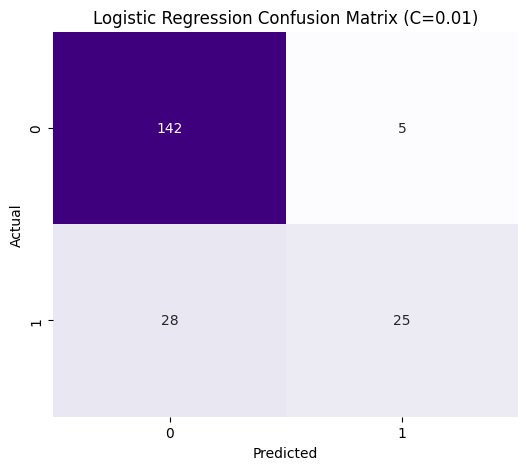

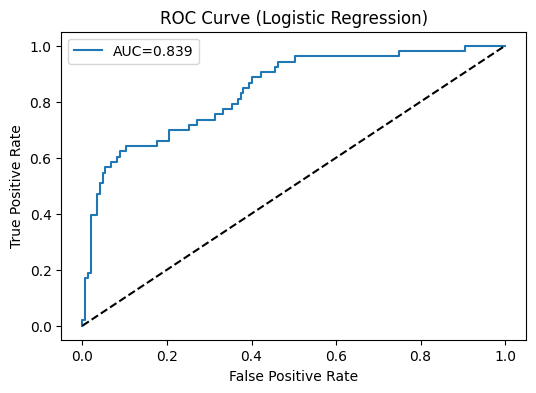

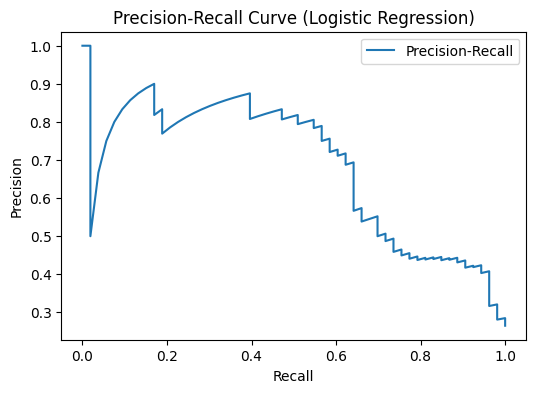

/tmp/ipykernel_15010/2437567860.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Abs_Coefficient", y="Feature", data=feat_df, palette=colors)


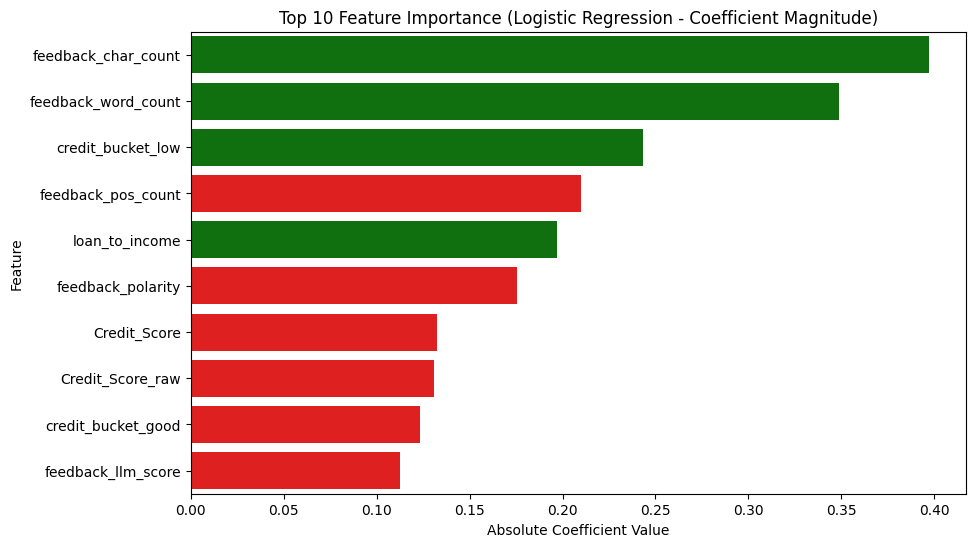


Top 10 Most Important Features:
            Feature  Coefficient
feedback_char_count     0.397110
feedback_word_count     0.348939
  credit_bucket_low     0.243509
 feedback_pos_count    -0.209739
     loan_to_income     0.196926
  feedback_polarity    -0.175523
       Credit_Score    -0.132707
   Credit_Score_raw    -0.131057
 credit_bucket_good    -0.123496
 feedback_llm_score    -0.112434

Note: Green bars = positive coefficient (increases default probability)
      Red bars = negative coefficient (decreases default probability)


In [28]:
# Model Evaluation
y_pred = lr_pipeline.predict(X_test)
y_proba = lr_pipeline.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
rmse = np.sqrt(mean_squared_error(y_test, y_proba))

print(f"\nFinal Model Accuracy: {accuracy:.2%}")
print(f"ROC AUC: {auc:.4f}")
print(f"RMSE: {rmse:.4f}\n")
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cmap='Purples', cbar=False)
plt.title(f"Logistic Regression Confusion Matrix (C={best_c})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label="Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Logistic Regression)")
plt.legend()
plt.show()

# Coefficient-based Feature Importance
# Extract coefficients from the logistic regression model
lr_model = lr_pipeline.named_steps['lr']
coefficients = lr_model.coef_[0]  # Get coefficients for the positive class

# Use absolute values for importance (magnitude of impact)
feat_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
}).sort_values(by="Abs_Coefficient", ascending=False).head(10)

plt.figure(figsize=(10,6))
colors = ['green' if c > 0 else 'red' for c in feat_df['Coefficient']]
sns.barplot(x="Abs_Coefficient", y="Feature", data=feat_df, palette=colors)
plt.title("Top 10 Feature Importance (Logistic Regression - Coefficient Magnitude)")
plt.xlabel("Absolute Coefficient Value")
plt.show()

print("\nTop 10 Most Important Features:")
print(feat_df[['Feature', 'Coefficient']].to_string(index=False))
print("\nNote: Green bars = positive coefficient (increases default probability)")
print("      Red bars = negative coefficient (decreases default probability)")

# Part 5: Model Evaluation

Side by side comparison for each models in terms of accuracy, precision, recall, f1-score, ROC-AUC values and ROC-AUC curves

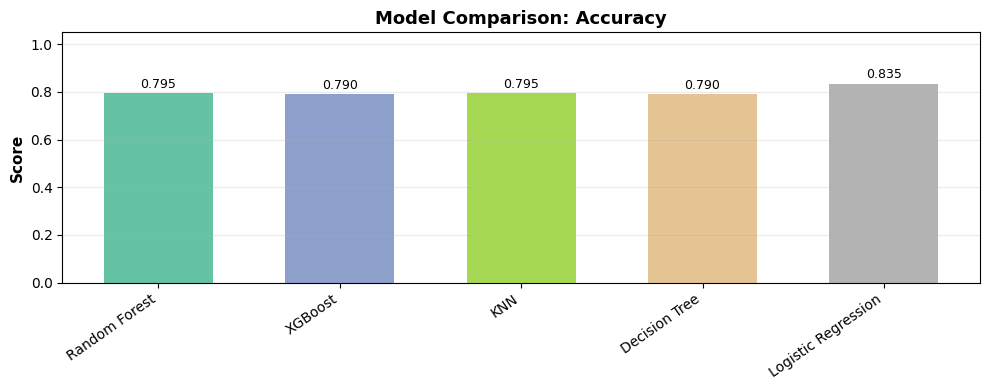

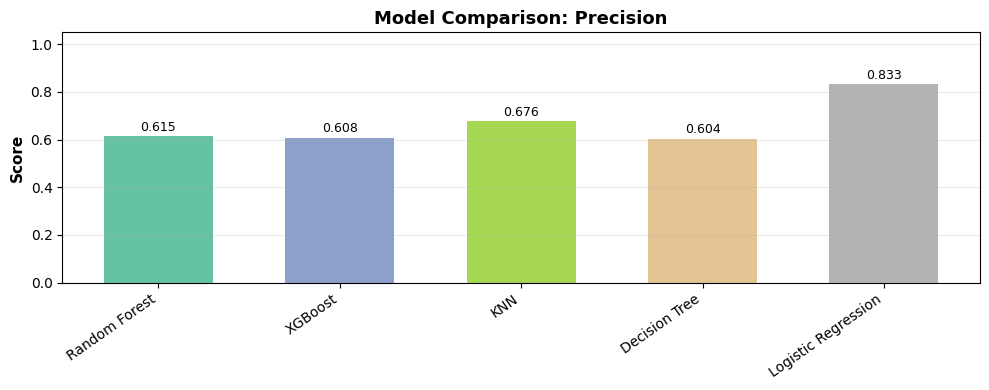

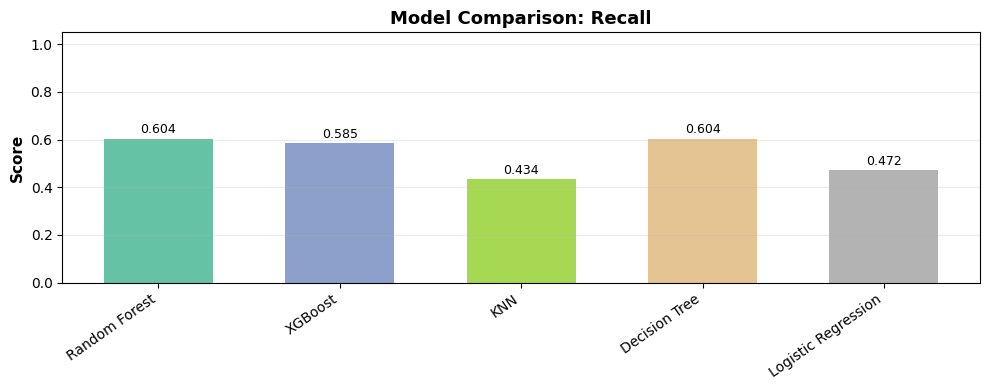

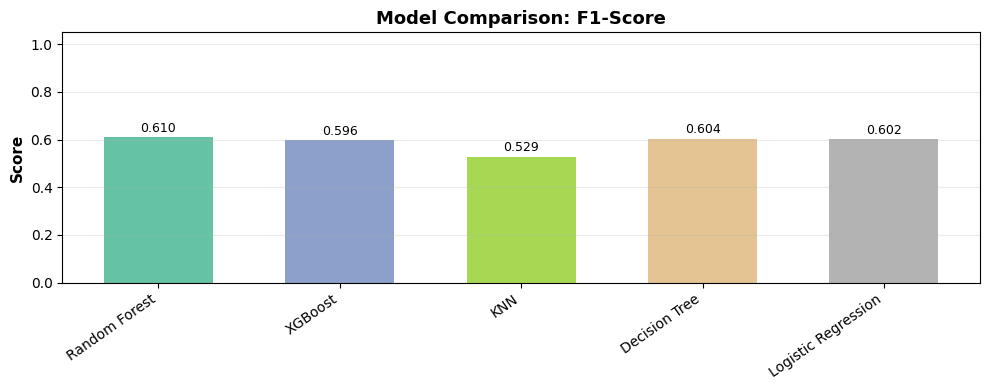

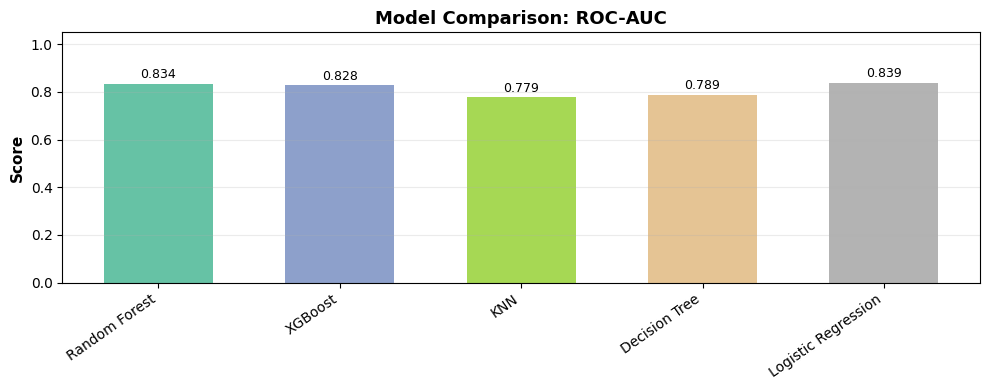

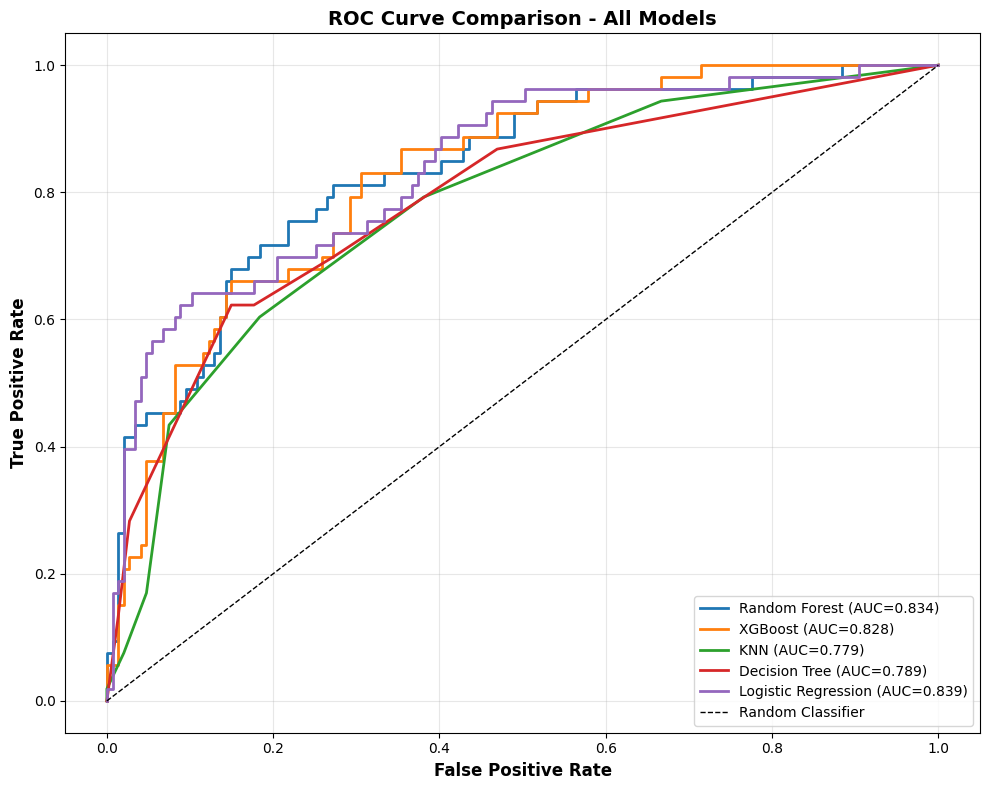


MODEL PERFORMANCE SUMMARY
                    accuracy precision    recall        f1   roc_auc
Random Forest          0.795  0.615385  0.603774  0.609524  0.834039
XGBoost                 0.79  0.607843  0.584906  0.596154   0.82775
KNN                    0.795  0.676471  0.433962  0.528736  0.778591
Decision Tree           0.79  0.603774  0.603774  0.603774  0.789051
Logistic Regression    0.835  0.833333  0.471698   0.60241  0.839173


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Collect metrics for all models
models_metrics = {}

# Model 1: Random Forest (best_rf)
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
models_metrics['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_proba_rf),
    'fpr': roc_curve(y_test, y_proba_rf)[0],
    'tpr': roc_curve(y_test, y_proba_rf)[1]
}

# Model 2: XGBoost
models_metrics['XGBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb),
    'recall': recall_score(y_test, y_pred_xgb),
    'f1': f1_score(y_test, y_pred_xgb),
    'roc_auc': roc_auc_xgb,
    'fpr': roc_curve(y_test, y_proba_xgb)[0],
    'tpr': roc_curve(y_test, y_proba_xgb)[1]
}

# Model 3: KNN
y_pred_knn = knn_pipeline.predict(X_test)
y_proba_knn = knn_pipeline.predict_proba(X_test)[:, 1]
models_metrics['KNN'] = {
    'accuracy': accuracy_score(y_test, y_pred_knn),
    'precision': precision_score(y_test, y_pred_knn),
    'recall': recall_score(y_test, y_pred_knn),
    'f1': f1_score(y_test, y_pred_knn),
    'roc_auc': roc_auc_score(y_test, y_proba_knn),
    'fpr': roc_curve(y_test, y_proba_knn)[0],
    'tpr': roc_curve(y_test, y_proba_knn)[1]
}

# Model 4: Decision Tree
models_metrics['Decision Tree'] = {
    'accuracy': accuracy_score(y_test, y_pred_best),
    'precision': precision_score(y_test, y_pred_best),
    'recall': recall_score(y_test, y_pred_best),
    'f1': f1_score(y_test, y_pred_best),
    'roc_auc': roc_auc_score(y_test, y_proba_dt),
    'fpr': roc_curve(y_test, y_proba_dt)[0],
    'tpr': roc_curve(y_test, y_proba_dt)[1]
}

# Model 5: Logistic Regression
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]
models_metrics['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'roc_auc': roc_auc_score(y_test, y_proba_lr),
    'fpr': roc_curve(y_test, y_proba_lr)[0],
    'tpr': roc_curve(y_test, y_proba_lr)[1]
}

model_names = list(models_metrics.keys())
metrics_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Plot 1: Accuracy, Precision, Recall, F1-Score, ROC-AUC Comparison (Bar Chart)
# Per-metric bar charts(one chart per metric)
title_map = {'accuracy': 'Accuracy', 'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1-Score', 'roc_auc': 'ROC-AUC'}

for metric in metrics_names:
    values = [models_metrics[model][metric] for model in model_names]
    x = np.arange(len(model_names))
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(x, values, width=0.6, color=plt.cm.Set2(np.linspace(0, 1, len(model_names))))
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=35, ha='right')
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(f'Model Comparison: {title_map.get(metric, metric)}', fontsize=13, fontweight='bold')
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', alpha=0.25)

    # Annotate bar values
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f'{h:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# Plot 2: ROC-AUC Curve Comparison
fig, ax = plt.subplots(figsize=(10, 8))
for model in model_names:
    fpr = models_metrics[model]['fpr']
    tpr = models_metrics[model]['tpr']
    auc = models_metrics[model]['roc_auc']
    ax.plot(fpr, tpr, linewidth=2, label=f'{model} (AUC={auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve Comparison - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print metrics summary table
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
metrics_df = pd.DataFrame(models_metrics).T
print(metrics_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].round(4))
print("="*80)